In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## DATA CLEANING AND EXPLORATION

In [142]:
#read data
df = pd.read_excel("C:/Users/fauziah/Desktop/ML & TIME SERIES PROJECT/2013-2023_ Monthly  Steel Production Data.xlsx", 'Monthly Steel Outlook', header = 1)

#Unpivot the table
df_unpivot2 = pd.melt(df, id_vars='Year ', value_vars=[ 'crude steel: January',
       'crude steel: February', 'crude steel: March', 'crude steel: April',
       'crude steel: May', 'crude steel: June', 'crude steel: July',
       'crude steel: August', 'crude steel: September', 'crude steel: October',
       'crude steel: November', 'crude steel: December'])
df_unpivot2.rename(columns = {'Year ':'Year'}, inplace = True)
df_unpivot2.Year = df_unpivot2.Year.astype(str)

#Remove character in the value and column that we dont need 
df_unpivot2['date'] =  df_unpivot2.Year.str[0:]+ " " + df_unpivot2.variable.str[13:]
df_unpivot2.columns = ['Year','t', 'value', 'date']
df_unpivot2 = df_unpivot2[['value', 'date']]

#Group by the date
df = df_unpivot2.groupby('date').sum().reset_index()

#Change date data type
df['date']=pd.to_datetime(df['date'])

#sort the date in ascending
df.sort_values(by='date', ascending = True, inplace = True)

#Set the index for date
df.set_index('date',inplace=True)

C:\Users\fauziah\AppData\Local\Temp\ipykernel_20388\2689081807.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date']=pd.to_datetime(df['date'])


In [145]:
df_unpivot2

,value,date
0,291.666667,2023 January
1,22.500000,2023 January
2,811.700000,2023 January
3,1.250000,2023 January
4,33.333333,2023 January
...,...,...
12415,5.229176,2014 December
12416,94.857000,2014 December
12417,36.627000,2014 December
12418,11.000000,2014 December


<Axes: xlabel='date'>

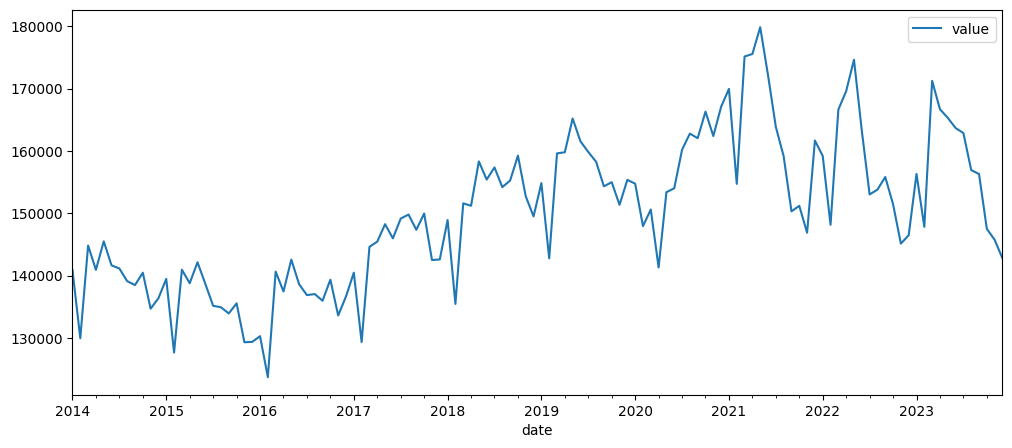

In [5]:
#Plot the actual data (group by date)

df.plot(figsize=(12,5))

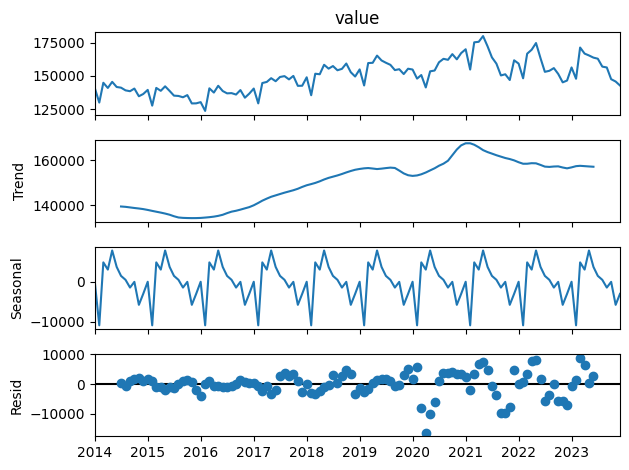

In [6]:
#Decompose Method

from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['value'],model='additive', period=12)
decompose.plot()
plt.show()

## MODEL 1

In [8]:
#df['Seasonal First Difference']=df['value']-df['value'].shift(12)
df['Seasonal First Difference'] = df['value'].diff().dropna()

<Axes: xlabel='date'>

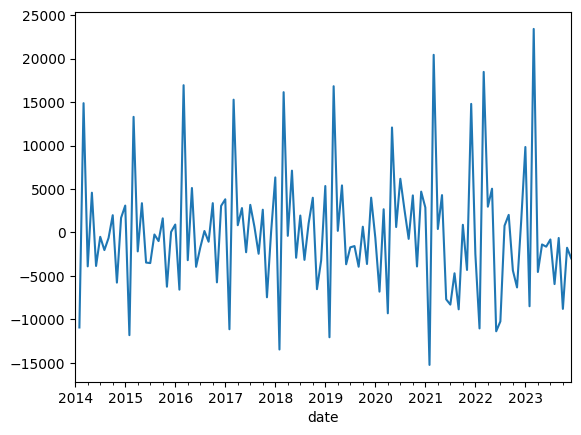

In [9]:
df['Seasonal First Difference'].plot()

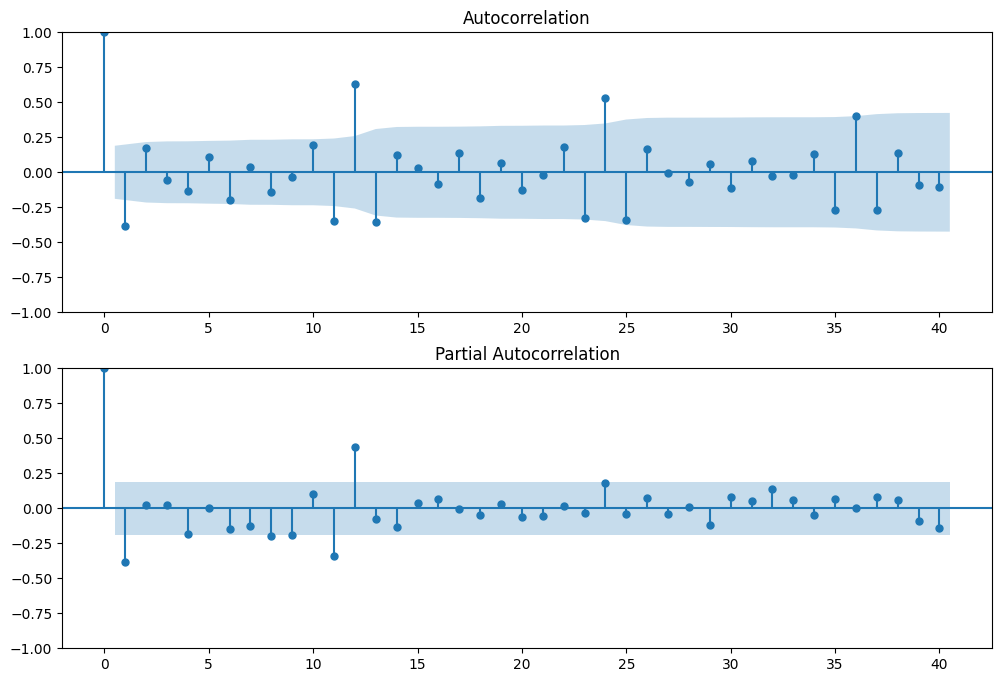

In [10]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [113]:
#run model, use value because already set in the order = p,d,q = 1,2,1
model=sm.tsa.statespace.SARIMAX(df['value'],order=(1, 2, 1),seasonal_order=(1,1,1,12))
results=model.fit()
results.summary()

C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  120
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood               -1064.180
Date:                            Tue, 05 Dec 2023   AIC                           2138.361
Time:                                    11:09:01   BIC                           2151.678
Sample:                                01-01-2014   HQIC                          2143.758
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3217      0.101      3.176      0.001       0.123       0.520
ma.L1         -0.9919      0.116     -8.573      0.000      -1.219      -0.765
ar.S.L12       0.6545      0.098      6.648      0.000       0.462       0.848
ma.S.L12      -0.9708      0.202     -4.802      0.000      -1.367      -0.575
sigma2      3.062e+07   8.33e-09   3.68e+15      0.000    3.06e+07    3.06e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.59   Jarque-Bera (JB):                 3.81
Prob(Q):                              0.03   Prob(JB):                         0.15
Heteroskedasticity (H):               3.53   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.87e+31. Standard errors may be unstable.
"""

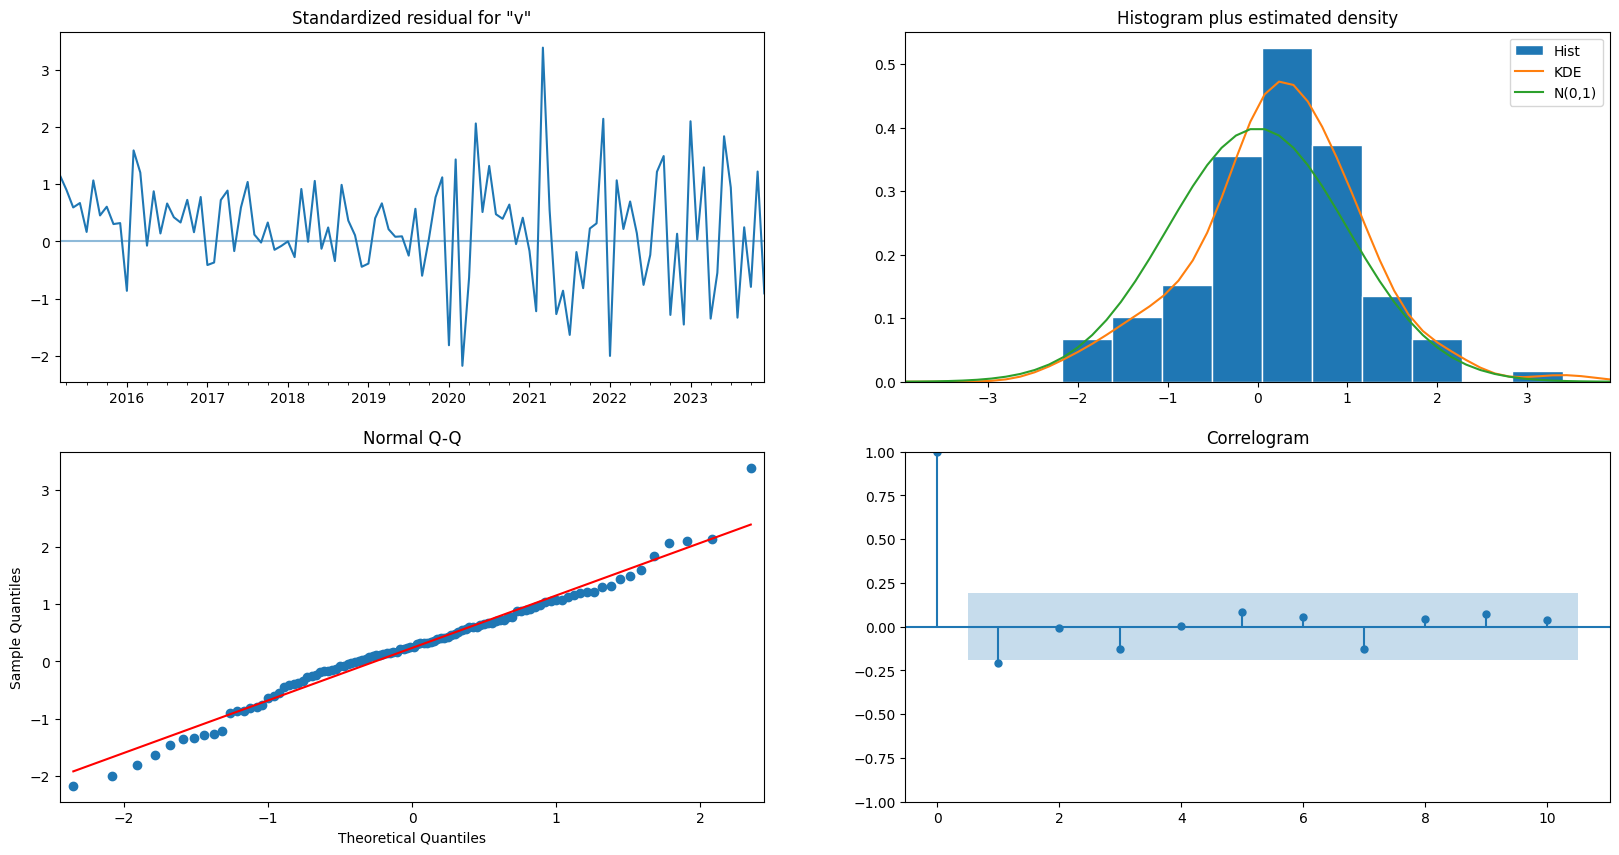

In [114]:
results.plot_diagnostics(figsize=(20, 10))
plt.show()

<Axes: xlabel='date'>

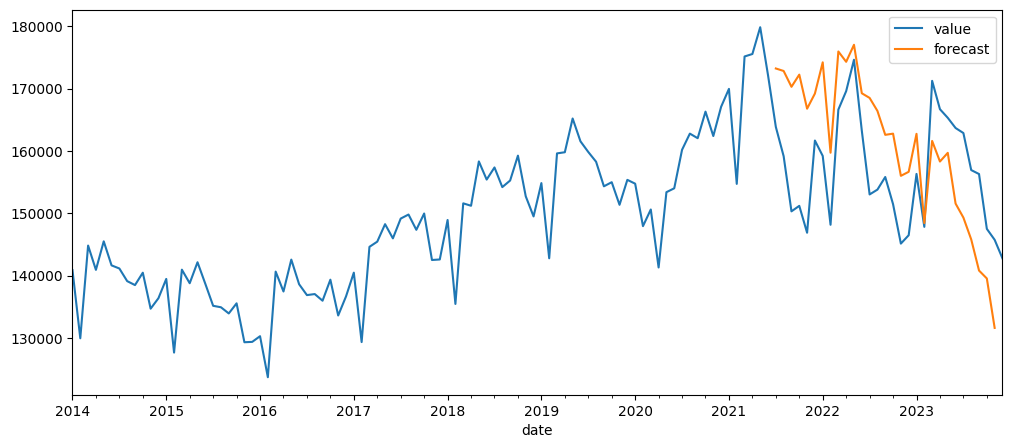

In [88]:
df['forecast']=results.predict(start=90,end=118,dynamic=True)
df[['value','forecast']].plot(figsize=(12,5))

## Model 2

-using hypermeter

In [11]:
model2=sm.tsa.statespace.SARIMAX(df['value'],order=(5, 2, 1),seasonal_order=(1,1,1,12))
results2=model2.fit()
results2.summary()

C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  120
Model:             SARIMAX(5, 2, 1)x(1, 1, 1, 12)   Log Likelihood               -1064.115
Date:                            Wed, 06 Dec 2023   AIC                           2146.231
Time:                                    09:36:15   BIC                           2170.202
Sample:                                01-01-2014   HQIC                          2155.946
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3084      0.118      2.616      0.009       0.077       0.539
ar.L2          0.0006      0.055      0.012      0.991      -0.108       0.109
ar.L3         -0.0135      0.074     -0.182      0.855      -0.158       0.131
ar.L4          0.0217      0.063      0.345      0.730      -0.101       0.145
ar.L5          0.0253      0.057      0.446      0.656      -0.086       0.137
ma.L1         -0.9873      0.106     -9.278      0.000      -1.196      -0.779
ar.S.L12       0.6474      0.146      4.419      0.000       0.360       0.935
ma.S.L12      -0.9286      0.207     -4.478      0.000      -1.335      -0.522
sigma2       3.41e+07   3.55e-09    9.6e+15      0.000    3.41e+07    3.41e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.02   Jarque-Bera (JB):                 2.92
Prob(Q):                              0.04   Prob(JB):                         0.23
Heteroskedasticity (H):               3.43   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.8e+30. Standard errors may be unstable.
"""

In [19]:
results2.aic

2146.230810851741

In [12]:
df['forecast']=results2.predict(start=90,end=118,dynamic=True)

<Axes: xlabel='date'>

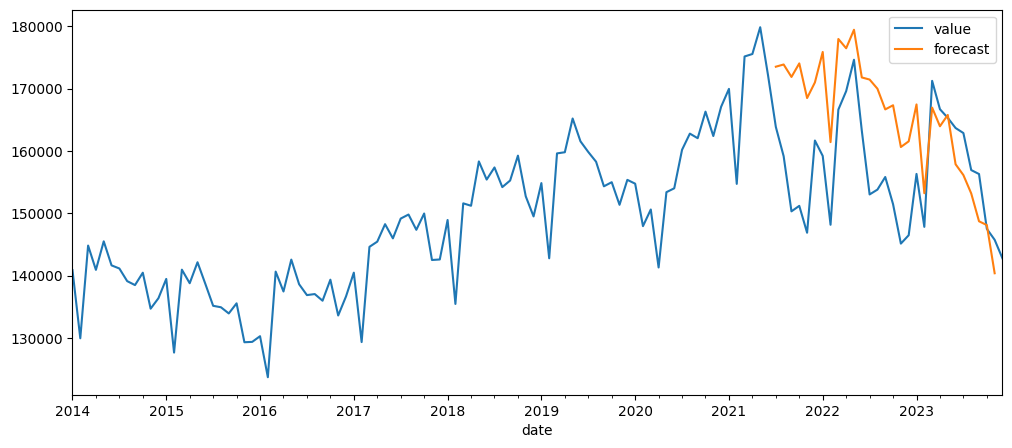

In [13]:
df[['value','forecast']].plot(figsize=(12,5))

In [62]:
df2 = df.dropna(subset=['value', 'forecast'])

<Axes: xlabel='date'>

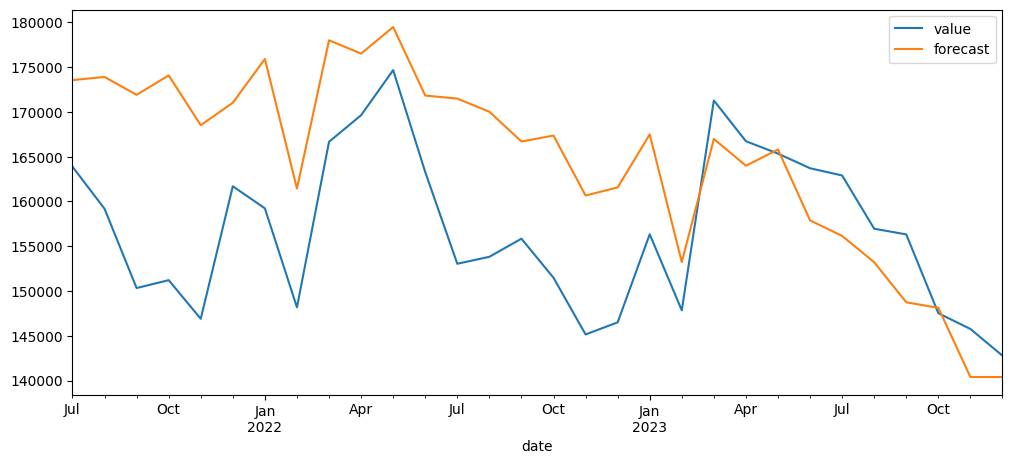

In [66]:
df2[['value','forecast']].plot(figsize=(12,5))

## RMSE

In [68]:
#MODEL 1

#run model, use value because already set in the order = p,d,q = 1,2,1
model=sm.tsa.statespace.SARIMAX(df['value'],order=(1, 2, 1),seasonal_order=(1,1,1,12))
results=model.fit()

df['forecast']=results.predict(start=90,end=118,dynamic=True)

#drop na
drop_na = df.dropna(subset=['value', 'forecast'])

# Evaluate the model
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(drop_na['value'], drop_na['forecast']))
print(f'Root Mean Squared Error (RMSE): {rmse}')

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Root Mean Squared Error (RMSE): 11846.644524160836


C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [69]:
#Model 2
#run model, use value because already set in the order = p,d,q = 1,2,1
model=sm.tsa.statespace.SARIMAX(df['value'],order=(2, 2, 1),seasonal_order=(1,1,1,12))
results=model.fit()

df['forecast']=results.predict(start=90,end=118,dynamic=True)

#drop na
drop_na = df.dropna(subset=['value', 'forecast'])

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(drop_na['value'], drop_na['forecast']))
print(f'Root Mean Squared Error (RMSE): {rmse}')

C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting M

Root Mean Squared Error (RMSE): 14105.829587609822


In [14]:
#Model 3
#run model, use value because already set in the order = p,d,q = 1,2,1
model=sm.tsa.statespace.SARIMAX(df['value'],order=(5, 2, 1),seasonal_order=(1,1,1,12))
results=model.fit()

df['forecast']=results.predict(start=90,end=118,dynamic=True)

#drop na
drop_na = df.dropna(subset=['value', 'forecast'])

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(drop_na['value'], drop_na['forecast']))
print(f'Root Mean Squared Error (RMSE): {rmse}')

C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Root Mean Squared Error (RMSE): 12282.982207824927


## EVALUATE ALL METRICS IN ONE TABLE

In [39]:
# Evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

#MODEL 1
model1=sm.tsa.statespace.SARIMAX(df['value'],order=(1, 2, 1),seasonal_order=(1,1,1,12))
results1=model1.fit()
#forecast value
df['forecast1']=results1.predict(start=90,end=118,dynamic=True)
#drop na
drop_na1 = df.dropna(subset=['value', 'forecast1'])
#metrics value
rmse1 = sqrt(mean_squared_error(drop_na1['value'], drop_na1['forecast1']))
mae1 = mean_absolute_error(drop_na1['value'], drop_na1['forecast1'])
mse1 = mean_squared_error(drop_na1['value'], drop_na1['forecast1'])

#MODEL 2
model2=sm.tsa.statespace.SARIMAX(df['value'],order=(2, 2, 1),seasonal_order=(1,1,1,12))
results2=model2.fit()
#forecast value
df['forecast2']=results2.predict(start=90,end=118,dynamic=True)
#drop na
drop_na2 = df.dropna(subset=['value', 'forecast2'])
#metrics value
rmse2 = sqrt(mean_squared_error(drop_na2['value'], drop_na2['forecast2']))
mae2 = mean_absolute_error(drop_na2['value'], drop_na2['forecast2'])
mse2 = mean_squared_error(drop_na2['value'], drop_na2['forecast2'])

#MODEL 3
model3=sm.tsa.statespace.SARIMAX(df['value'],order=(5, 2, 1),seasonal_order=(1,1,1,12))
results3=model3.fit()
#forecast value
df['forecast3']=results3.predict(start=90,end=118,dynamic=True)
#drop na
drop_na3 = df.dropna(subset=['value', 'forecast3'])
#metrics value
rmse3 = sqrt(mean_squared_error(drop_na3['value'], drop_na3['forecast1']))
mae3 = mean_absolute_error(drop_na3['value'], drop_na3['forecast1'])
mse3 = mean_squared_error(drop_na3['value'], drop_na3['forecast1'])
#AIC Value
AIC1 = results1.aic
AIC2 = results2.aic
AIC3 = results3.aic

C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Pr

In [28]:
print(rmse1)
print(mae1)
print(mse1)
print(AIC1)

12282.982207824927
10586.981138986415
150871651.91774374
2146.230810851741


In [40]:
results_evaluation = pd.DataFrame({'Model': ['MODEL 1', 'MODEL 2', 'MODEL 3'],
                        'RMSE' : [rmse1, rmse2, rmse3 ],
                        'MSE': [mse1, mse2, mse3 ],
                        'mae1': [mae1, mae2, mae3],
                       'AIC': [AIC1, AIC2, AIC3]})


In [41]:
results_evaluation

,Model,RMSE,MSE,mae1,AIC
0,MODEL 1,11846.644524,1.403430e+08,10788.506306,2138.360838
1,MODEL 2,14105.829588,1.989744e+08,12247.082715,2142.132625
2,MODEL 3,11846.644524,1.403430e+08,10788.506306,2146.230811


## Predict the future

In [42]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [43]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [44]:
future_datest_df

,value,forecast1,forecast2,forecast3
2024-01-01,NaN,NaN,NaN,NaN
2024-02-01,NaN,NaN,NaN,NaN
2024-03-01,NaN,NaN,NaN,NaN
2024-04-01,NaN,NaN,NaN,NaN
2024-05-01,NaN,NaN,NaN,NaN
2024-06-01,NaN,NaN,NaN,NaN
2024-07-01,NaN,NaN,NaN,NaN
2024-08-01,NaN,NaN,NaN,NaN
2024-09-01,NaN,NaN,NaN,NaN
2024-10-01,NaN,NaN,NaN,NaN


In [46]:
future_df=pd.concat([df,future_datest_df])

In [47]:
future_df['forecast'] = results1.predict(start = 120, end = 139, dynamic= True)  
future_df

,value,forecast1,forecast2,forecast3,forecast
2014-01-01,140887.513341,NaN,NaN,NaN,NaN
2014-02-01,129953.978091,NaN,NaN,NaN,NaN
2014-03-01,144832.952386,NaN,NaN,NaN,NaN
2014-04-01,140932.008760,NaN,NaN,NaN,NaN
2014-05-01,145507.403678,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-07-01,NaN,NaN,NaN,NaN,118291.721384
2025-08-01,NaN,NaN,NaN,NaN,111681.884145
2025-09-01,NaN,NaN,NaN,NaN,NaN
2025-10-01,NaN,NaN,NaN,NaN,NaN


In [48]:
future_df.tail(50)

,value,forecast1,forecast2,forecast3,forecast
2021-10-01,151200.759333,172255.815852,174416.177211,174058.220869,NaN
2021-11-01,146885.818333,166790.854874,169345.178828,168498.484898,NaN
2021-12-01,161682.488333,169222.760011,172197.089603,171004.978973,NaN
2022-01-01,159211.710763,174226.453513,177151.962022,175889.590626,NaN
2022-02-01,148165.773660,159727.327563,162826.441643,161427.763811,NaN
2022-03-01,166643.561230,175969.129429,179708.188630,177975.914526,NaN
2022-04-01,169611.476670,174314.428541,178447.954038,176487.281162,NaN
2022-05-01,174645.675650,177045.012903,181723.460779,179455.168617,NaN
2022-06-01,163270.803970,169267.056558,174304.243430,171805.795555,NaN
2022-07-01,153031.685660,168519.741873,174511.916928,171465.094875,NaN


<Axes: >

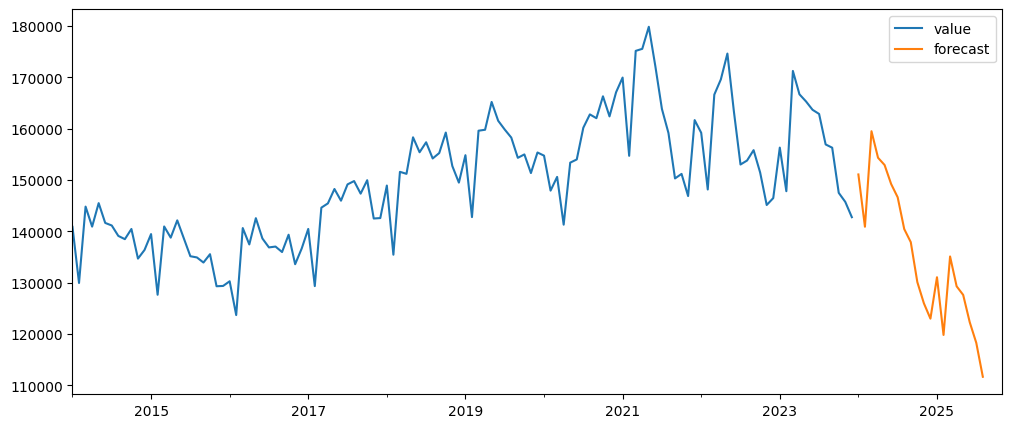

In [49]:
future_df[['value','forecast']].plot(figsize=(12,5))

In [50]:
agg_data = future_df.reset_index()
agg_data

,index,value,forecast1,forecast2,forecast3,forecast
0,2014-01-01,140887.513341,NaN,NaN,NaN,NaN
1,2014-02-01,129953.978091,NaN,NaN,NaN,NaN
2,2014-03-01,144832.952386,NaN,NaN,NaN,NaN
3,2014-04-01,140932.008760,NaN,NaN,NaN,NaN
4,2014-05-01,145507.403678,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
138,2025-07-01,NaN,NaN,NaN,NaN,118291.721384
139,2025-08-01,NaN,NaN,NaN,NaN,111681.884145
140,2025-09-01,NaN,NaN,NaN,NaN,NaN
141,2025-10-01,NaN,NaN,NaN,NaN,NaN


In [51]:
agg_data['year'] = agg_data['index'].dt.year
agg_data

,index,value,forecast1,forecast2,forecast3,forecast,year
0,2014-01-01,140887.513341,NaN,NaN,NaN,NaN,2014
1,2014-02-01,129953.978091,NaN,NaN,NaN,NaN,2014
2,2014-03-01,144832.952386,NaN,NaN,NaN,NaN,2014
3,2014-04-01,140932.008760,NaN,NaN,NaN,NaN,2014
4,2014-05-01,145507.403678,NaN,NaN,NaN,NaN,2014
...,...,...,...,...,...,...,...
138,2025-07-01,NaN,NaN,NaN,NaN,118291.721384,2025
139,2025-08-01,NaN,NaN,NaN,NaN,111681.884145,2025
140,2025-09-01,NaN,NaN,NaN,NaN,NaN,2025
141,2025-10-01,NaN,NaN,NaN,NaN,NaN,2025


In [52]:
data_average = agg_data.groupby(agg_data.year)['forecast'].mean()
data_average = pd.DataFrame(data_average)
data_average

,forecast
year,
2014,NaN
2015,NaN
2016,NaN
2017,NaN
2018,NaN
2019,NaN
2020,NaN
2021,NaN
2022,NaN


In [53]:
data_average_v = agg_data.groupby(agg_data.year)['value'].mean()
data_average_v = pd.DataFrame(data_average_v)
data_average_v

,value
year,
2014,139507.512565
2015,135501.131163
2016,136071.241937
2017,144630.965250
2018,152441.592417
2019,156502.818972
2020,156909.822750
2021,163381.666333
2022,157276.572276


In [54]:
data_average_v['forecast'] =  data_average['forecast']

In [55]:
data_average_v

,value,forecast
year,,
2014,139507.512565,NaN
2015,135501.131163,NaN
2016,136071.241937,NaN
2017,144630.965250,NaN
2018,152441.592417,NaN
2019,156502.818972,NaN
2020,156909.822750,NaN
2021,163381.666333,NaN
2022,157276.572276,NaN


In [56]:
data_average_v = data_average_v.reset_index()

In [57]:
data_average_v['year']

0     2014
1     2015
2     2016
3     2017
4     2018
5     2019
6     2020
7     2021
8     2022
9     2023
10    2024
11    2025
Name: year, dtype: int32

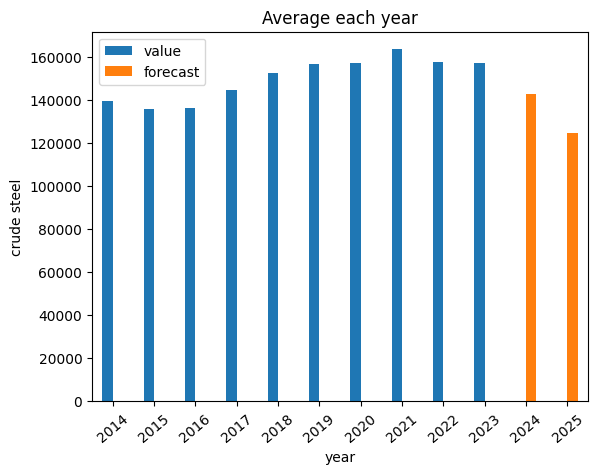

In [126]:
data_average_v.plot.bar(x = 'year', y = ['value', 'forecast'], rot = 40)
# function to add value labels
def addlabels(y):
    for i in range(len(y)):
        plt.text(i,y[i],y[i], rotation = 40)

def addlabels2(c):
    for i in range(len(c)):
        plt.text(i,c[i],c[i])
        
fig = plt.figure(1, figsize=(50, 14), frameon=False, dpi=90)



# y = data_average_v['value']
# c = data_average_v['forecast']
# addlabels(y)
# addlabels(c)
plt.xlabel("year")
plt.ylabel("crude steel")
plt.title("Average each year")
plt.show()

# ASIA WITHOUT CHINA

In [170]:
#read data
df = pd.read_excel("C:/Users/fauziah/Desktop/ML & TIME SERIES PROJECT/2013-2023_ Monthly  Steel Production Data.xlsx", 'Monthly Steel Outlook', header = 1)

#Unpivot the table
df_unpivot2 = pd.melt(df, id_vars=['Year ', 'Resoanc Regions '], value_vars=[ 'crude steel: January',
       'crude steel: February', 'crude steel: March', 'crude steel: April',
       'crude steel: May', 'crude steel: June', 'crude steel: July',
       'crude steel: August', 'crude steel: September', 'crude steel: October',
       'crude steel: November', 'crude steel: December'])
df_unpivot2.rename(columns = {'Year ':'Year'}, inplace = True)
df_unpivot2.Year = df_unpivot2.Year.astype(str)

# selecting rows based on condition 
df_unpivot2 = df_unpivot2[df_unpivot2['Resoanc Regions '] == 'Asia'] 

#Remove character in the value and column that we dont need 
df_unpivot2['date'] =  df_unpivot2.Year.str[0:]+ " " + df_unpivot2.variable.str[13:]
#df_unpivot2.columns = ['Year','t', 'value', 'date']
df_unpivot2 = df_unpivot2[['value', 'date']]

#Group by the date
df = df_unpivot2.groupby('date').sum().reset_index()

#Change date data type
df['date']=pd.to_datetime(df['date'])

#sort the date in ascending
df.sort_values(by='date', ascending = True, inplace = True)

#Set the index for date
df.set_index('date',inplace=True)

C:\Users\fauziah\AppData\Local\Temp\ipykernel_20388\1382678098.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date']=pd.to_datetime(df['date'])


In [171]:
df

,value
date,
2014-01-01,19497.900000
2014-02-01,17807.314000
2014-03-01,20309.327000
2014-04-01,19209.370000
2014-05-01,19971.517000
...,...
2023-08-01,19360.406633
2023-09-01,19258.351268
2023-10-01,19054.511848


<Axes: xlabel='date'>

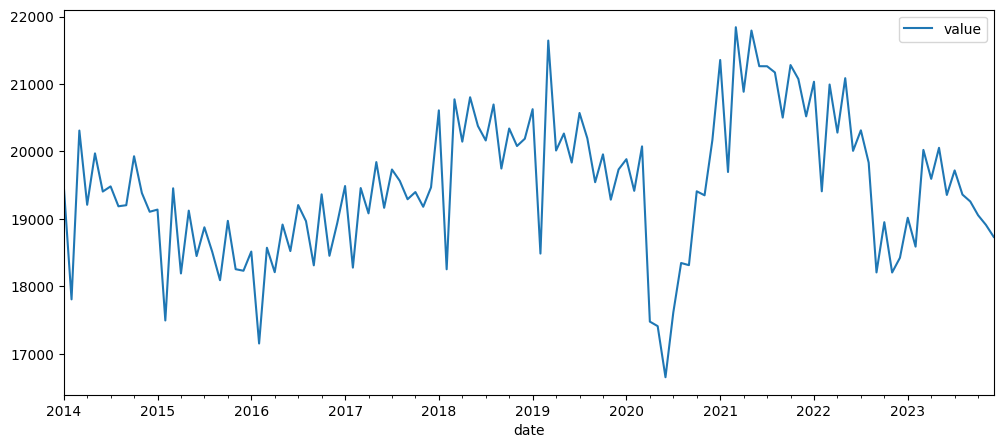

In [172]:
df.plot(figsize=(12,5))

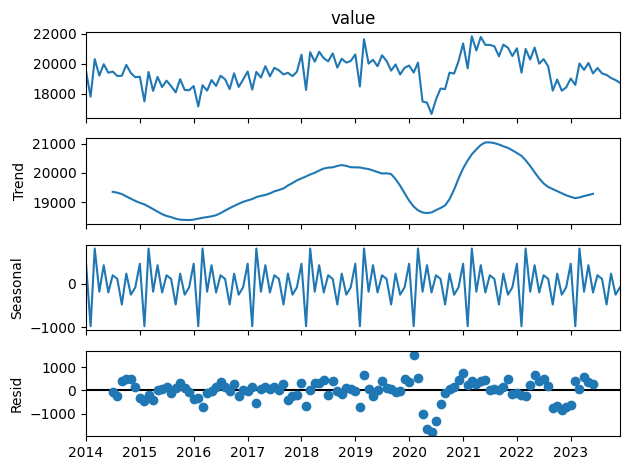

In [173]:
#Decompose Method

from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['value'],model='additive', period=12)
decompose.plot()
plt.show()


<Axes: xlabel='date'>

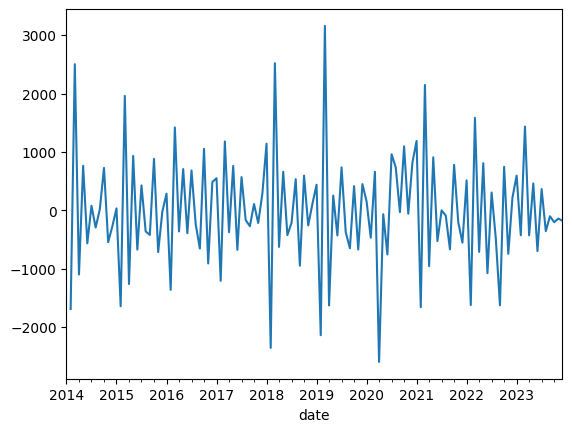

In [174]:
#df['Seasonal First Difference']=df['value']-df['value'].shift(12)
df['Seasonal First Difference'] = df['value'].diff().dropna()

df['Seasonal First Difference'].plot()

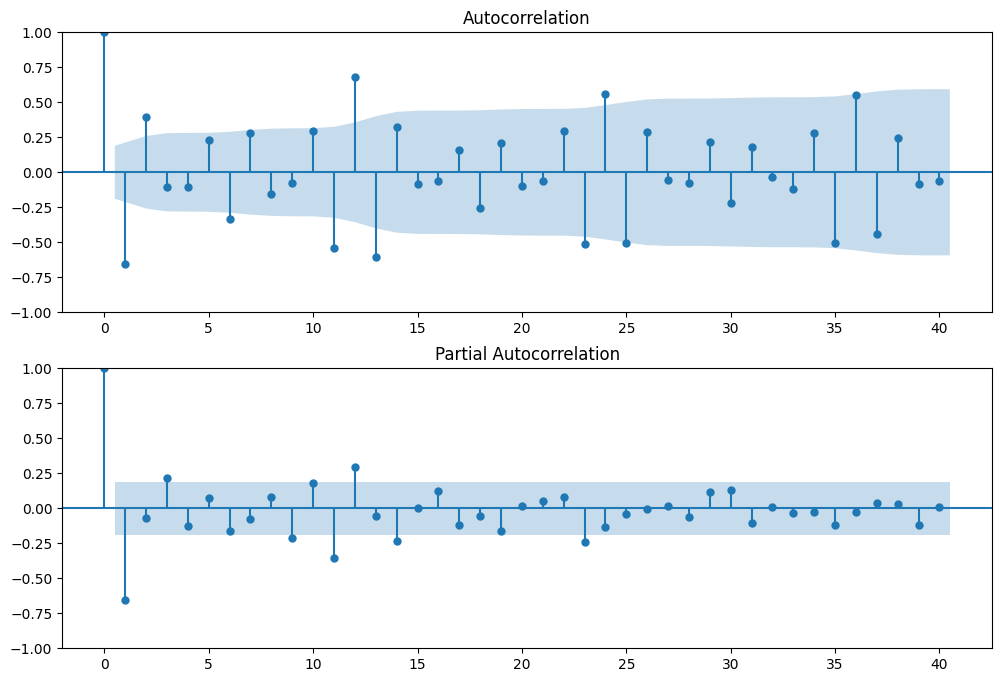

In [175]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)


In [209]:
#run model, use value because already set in the order = p,d,q = 1,2,1
model=sm.tsa.statespace.SARIMAX(df['value'],order=(1, 2, 1),seasonal_order=(1,1,1,12))
results=model.fit()
results.summary()


C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  120
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                -842.789
Date:                            Wed, 06 Dec 2023   AIC                           1695.577
Time:                                    16:48:31   BIC                           1708.894
Sample:                                01-01-2014   HQIC                          1700.975
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.067      0.219      0.827      -0.116       0.146
ma.L1         -0.7250      0.090     -8.059      0.000      -0.901      -0.549
ar.S.L12       0.2672      0.075      3.544      0.000       0.119       0.415
ma.S.L12      -0.9976      0.126     -7.887      0.000      -1.246      -0.750
sigma2       2.72e+05   4.69e-07    5.8e+11      0.000    2.72e+05    2.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.06   Jarque-Bera (JB):                 1.59
Prob(Q):                              0.08   Prob(JB):                         0.45
Heteroskedasticity (H):               0.84   Skew:                             0.11
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.51e+26. Standard errors may be unstable.
"""

<Axes: xlabel='date'>

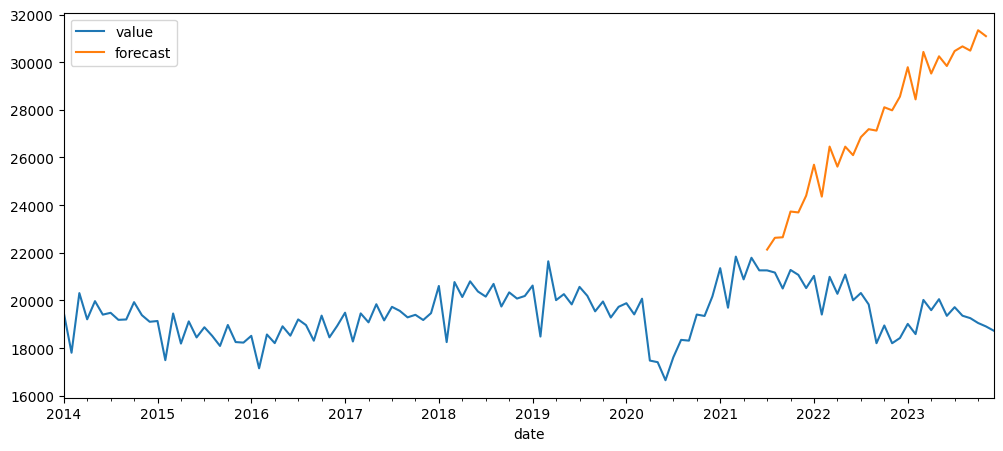

In [211]:
df['forecast']=results.predict(start=90,end=118,dynamic=True)
df[['value','forecast']].plot(figsize=(12,5))

In [215]:
model=sm.tsa.arima.ARIMA(df['value'],order=(1,2,1))
model_fit=model.fit()

C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\fauziah\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [216]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -982.446
Date:                Wed, 06 Dec 2023   AIC                           1970.891
Time:                        16:51:01   BIC                           1979.203
Sample:                    01-01-2014   HQIC                          1974.266
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4816      0.027    -18.009      0.000      -0.534      -0.429
ma.L1         -0.5124      0.051     -9.968      0.000      -0.613      -0.412
sigma2      6.617e+05   7.05e+04      9.392      0.000    5.24e+05       8e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.35   Jarque-Bera (JB):                25.75
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.48
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date'>

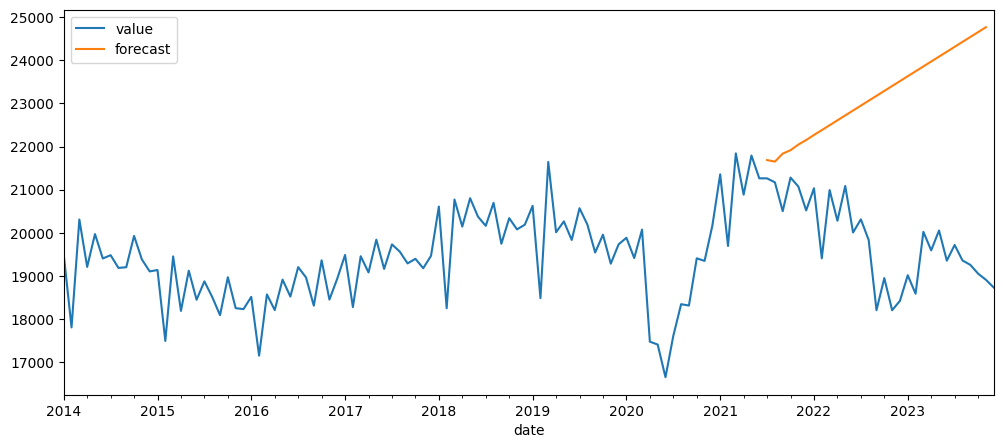

In [217]:
df['forecast']=model_fit.predict(start=90,end=118,dynamic=True)
df[['value','forecast']].plot(figsize=(12,5))

# EMEA

# Americas

# Overall Conclusion

In [3]:
import os
os.getcwd()

'C:\\Users\\fauziah\\AppData\\Local\\Programs\\Python\\Python39\\Scripts'